In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
file_path = r"C:\Users\april\Documents\MSDS\Capstone\WWLLN_rainband_timebin_count.csv"

df = pd.read_csv(file_path)

print(df.head())

  storm_code             time_bin  lightining_count
0   ATL_10_1  2010-06-20 17:30:00                 2
1   ATL_10_1  2010-06-20 18:00:00                58
2   ATL_10_1  2010-06-20 18:30:00                31
3   ATL_10_1  2010-06-20 19:00:00                32
4   ATL_10_1  2010-06-20 19:30:00                34


In [16]:
print(df.shape)

(130391, 3)


In [6]:
unique_count = df['storm_code'].nunique()

print(unique_count) 

472


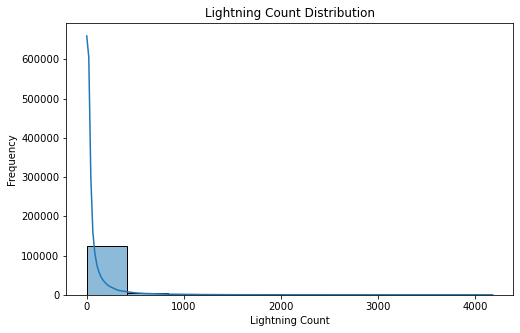

In [17]:
#checking for skewness of the lightning count

plt.figure(figsize=(8, 5))
sns.histplot(df['lightining_count'], bins=10, kde=True)
plt.title('Lightning Count Distribution')
plt.xlabel('Lightning Count')
plt.ylabel('Frequency')
plt.show()

#The histogram suggests that the lightning count data is highly skewed to the right 
# Most of the lightning count values are clustered near the lower end, with a long tail extending toward higher values.

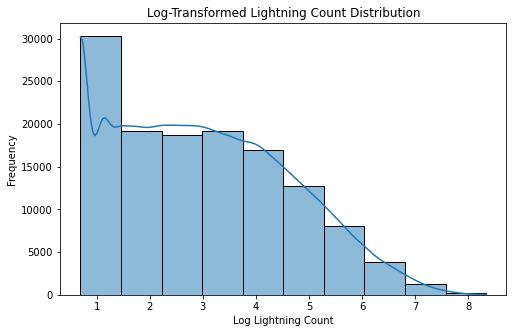

In [19]:
# Apply log transformation (adding 1 to avoid log(0) issues)
df['log_lightning_count'] = np.log1p(df['lightining_count'])

# Plot the transformed data
plt.figure(figsize=(8, 5))
sns.histplot(df['log_lightning_count'], bins=10, kde=True)
plt.title('Log-Transformed Lightning Count Distribution')
plt.xlabel('Log Lightning Count')
plt.ylabel('Frequency')
plt.show()


In [22]:
#Aproach 1: Z-Score with Median Absolute Deviation (MAD):is robust to skewed distributions
from scipy.stats import median_abs_deviation

median_log = df['log_lightning_count'].median()
mad_log = median_abs_deviation(df['log_lightning_count'])

# Define threshold using 2.5 scaled MAD (adjustable based on sensitivity)
mad_threshold = median_log + 2.5 * mad_log

# Identify bursts using MAD
df['burst_mad'] = df['log_lightning_count'] > mad_threshold



In [23]:
#Approach 2: interquartile Range (IQR) Method

Q1 = df['log_lightning_count'].quantile(0.25)
Q3 = df['log_lightning_count'].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for IQR method (1.5 * IQR rule)
iqr_threshold = Q3 + 1.5 * IQR

# Identify bursts using IQR
df['burst_iqr'] = df['log_lightning_count'] > iqr_threshold



In [25]:
# Compare burst detection methods
comparison = df[['time_bin', 'lightining_count', 'burst_iqr', 'burst_mad']]

# Find mismatched results
mismatch = comparison[comparison['burst_iqr'] != comparison['burst_mad']]
print(mismatch)


                   time_bin  lightining_count  burst_iqr  burst_mad
342     2010-06-28 19:00:00               436      False       True
1222    2010-09-11 15:30:00               599      False       True
1223    2010-09-11 16:00:00               414      False       True
1264    2010-09-12 15:30:00               417      False       True
1265    2010-09-12 16:00:00               474      False       True
...                     ...               ...        ...        ...
130208  2020-08-22 13:30:00               485      False       True
130210  2020-08-22 14:30:00               563      False       True
130240  2020-08-23 05:30:00               422      False       True
130241  2020-08-23 06:00:00               449      False       True
130337  2020-08-25 15:30:00               410      False       True

[5652 rows x 4 columns]


In [26]:
iqr_bursts_count = df['burst_iqr'].sum()
mad_bursts_count = df['burst_mad'].sum()

print(f"Number of bursts detected by IQR: {iqr_bursts_count}")
print(f"Number of bursts detected by MAD: {mad_bursts_count}")


Number of bursts detected by IQR: 19
Number of bursts detected by MAD: 5671


#### cyclone specific burst detection 

In [29]:
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    upper_threshold = Q3 + 1.5 * IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr'] = group['log_lightning_count'] > upper_threshold
    return group

df['log_lightning_count'] = np.log1p(df['lightining_count'])
df = df.groupby('storm_code', group_keys=False).apply(detect_bursts_iqr)

# Check the burst detection for a few cyclones
print(df[df['burst_iqr'] == True][['storm_code', 'time_bin', 'lightining_count']])


       storm_code             time_bin  lightining_count
924     ATL_10_12  2010-09-12 06:00:00               150
925     ATL_10_12  2010-09-12 06:30:00               150
926     ATL_10_12  2010-09-12 07:00:00               230
927     ATL_10_12  2010-09-12 07:30:00               140
928     ATL_10_12  2010-09-12 08:00:00               224
...           ...                  ...               ...
129899  WPAC_20_3  2020-08-04 03:30:00               212
129900  WPAC_20_3  2020-08-04 04:00:00               122
129903  WPAC_20_3  2020-08-04 05:30:00               165
129906  WPAC_20_3  2020-08-04 07:00:00               193
129907  WPAC_20_3  2020-08-04 07:30:00               202

[215 rows x 3 columns]


In [30]:
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold = median_log + 2.5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad'] = group['log_lightning_count'] > threshold
    return group

df = df.groupby('storm_code', group_keys=False).apply(detect_bursts_mad)

# Check the burst detection for a few cyclones
print(df[df['burst_mad'] == True][['storm_code', 'time_bin', 'lightining_count']])


       storm_code             time_bin  lightining_count
254      ATL_10_1  2010-06-26 21:00:00               370
277      ATL_10_1  2010-06-27 08:30:00               374
341      ATL_10_1  2010-06-28 18:30:00               386
342      ATL_10_1  2010-06-28 19:00:00               436
350      ATL_10_1  2010-06-28 23:00:00               393
...           ...                  ...               ...
130207  WPAC_20_9  2020-08-22 13:00:00               429
130208  WPAC_20_9  2020-08-22 13:30:00               485
130210  WPAC_20_9  2020-08-22 14:30:00               563
130240  WPAC_20_9  2020-08-23 05:30:00               422
130241  WPAC_20_9  2020-08-23 06:00:00               449

[4318 rows x 3 columns]


In [31]:
comparison = df.groupby('storm_code')[['burst_iqr', 'burst_mad']].sum()

print(comparison)


            burst_iqr  burst_mad
storm_code                      
ATL_10_1            0          6
ATL_10_11           0          1
ATL_10_12           6         24
ATL_10_13           0          5
ATL_10_14           0         10
...               ...        ...
WPAC_20_22          0         12
WPAC_20_25          0          2
WPAC_20_3           6         21
WPAC_20_7           0          4
WPAC_20_9           0          7

[472 rows x 2 columns]


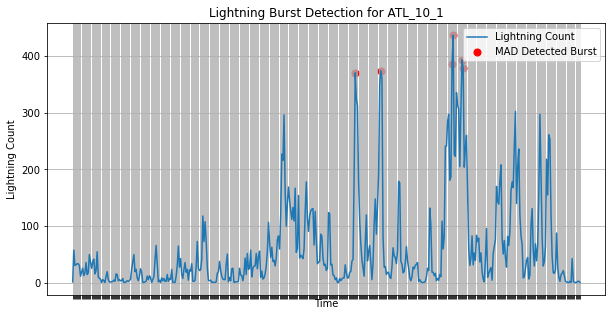

In [36]:
import matplotlib.pyplot as plt

# Select a specific cyclone to visualize
cyclone_id = 'ATL_10_1'
df_cyclone = df[df['storm_code'] == cyclone_id]

plt.figure(figsize=(10, 5))
plt.plot(df_cyclone['time_bin'], df_cyclone['lightining_count'], label='Lightning Count')

# Mark bursts detected by MAD
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad']], 
            df_cyclone['lightining_count'][df_cyclone['burst_mad']], 
            color='red', label='MAD Detected Burst', s=50, marker='o')

plt.xlabel('Time')
plt.ylabel('Lightning Count')
plt.title(f'Lightning Burst Detection for {cyclone_id}')
plt.legend()
plt.xticks(visible=False)
plt.grid()
plt.show()


In [41]:
df['log_lightning_count'] = np.log1p(df['lightining_count'])  # Log transformation
df['rolling_mean_log'] = df.groupby('storm_code')['log_lightning_count'].transform(lambda x: x.rolling(window=3, min_periods=2).mean())
df['rolling_std_log'] = df.groupby('storm_code')['log_lightning_count'].transform(lambda x: x.rolling(window=3, min_periods=2).std())

df['rolling_zscore_log'] = (df['log_lightning_count'] - df['rolling_mean_log']) / df['rolling_std_log']
df['burst_zscore_log'] = df['rolling_zscore_log'] > 1.5

print(df[df['burst_zscore_log'] == True][['storm_code', 'time_bin', 'lightining_count', 'rolling_zscore_log']])


        storm_code             time_bin  lightining_count  rolling_zscore_log
959      ATL_10_12  2010-09-14 03:00:00                 1                 inf
960      ATL_10_12  2010-09-14 06:30:00                 1                 inf
961      ATL_10_12  2010-09-14 08:30:00                 1                 inf
962      ATL_10_12  2010-09-14 09:30:00                 1                 inf
982      ATL_10_12  2010-09-14 22:30:00                 1                 inf
...            ...                  ...               ...                 ...
128011  WPAC_20_10  2020-09-02 19:00:00                 1                 inf
128020  WPAC_20_10  2020-09-03 07:00:00                 1                 inf
128244  WPAC_20_11  2020-09-05 07:30:00                 1                 inf
128245  WPAC_20_11  2020-09-05 08:30:00                 1                 inf
129919   WPAC_20_3  2020-08-04 16:00:00                 1                 inf

[338 rows x 4 columns]


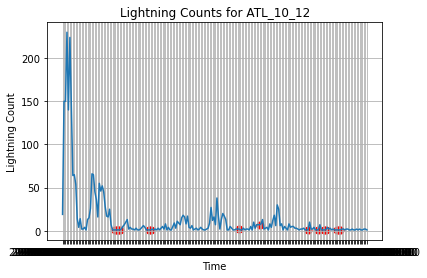

In [45]:
cyclone_id = 'ATL_10_12'
df_cyclone = df[df['storm_code'] == cyclone_id]

plt.plot(df_cyclone['time_bin'], df_cyclone['lightining_count'], label='Lightning Count')
plt.scatter(df_cyclone['time_bin'][df_cyclone['burst_zscore_log']], 
            df_cyclone['lightining_count'][df_cyclone['burst_zscore_log']], 
            color='red', label='Z score Detected Burst', s=50, marker='o')
plt.xlabel('Time')
plt.ylabel('Lightning Count')
plt.title(f'Lightning Counts for {cyclone_id}')
plt.grid()
plt.show()
